# Does traffic correlate with pollution?

The above question has been answered in this jupyter notebook. Different methods have been tried before concluding that there is some correlation relation between traffic on the streets of Kampala, Uganda and the pollution measured by the US Embassy in the capital. Even though the R2 values from the GLMs are not that significant, it can be concluded that several other factors could play a role in this, the details of which have been discussed in the report. Apart from this, some correlation between traffic alone and pollution has been observed, and the code below helps to lead the reader to it.

### Code module for all the necessary imports

In [1]:
"""
all imports
"""
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob
import errno
import pandas as pd
from datetime import datetime
import time
import datetime
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
import math
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

### Function fetchMapDate():

This function scans through all the Google Maps for the city of Kampala taken every 15 mins for close to two months, extracts their names (given in date time format) and returns a list of those names in UTC format.

In [2]:
"""
scans through all the maps, 
picks their names,
formats those and returns them in a list 
"""

def fetchMapDate():
    path = '/home/vijeta/Documents/Dissertation/*.png'
    files = glob.glob(path)
    maplist = []
    datelist = []
    timelist = []
    dtlist = []
    for name in files:
        try:
            with open(name) as f:
                filename = re.split("[map]", name)[-2][:-1]
                maplist.append(filename)
                date, time = re.split("_", filename)
                mm, dd, yy = [date[i:i+2] for i in range(0, len(date), 2)]
                yy = '20'+yy
                hh, mi, ss = [time[i:i+2] for i in range(0, len(time), 2)]
                n_date = '-'.join([yy,mm,dd])
                datelist.append(n_date)
                n_time = ':'.join([hh,mi,ss])
                timelist.append(n_time)
                datetime = ' '.join([n_date,n_time])
                dtlist.append(datetime)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return (dtlist)

### Function fetchPollutionDate():

This function converts the column **date.utc** of the pollution data received from the US Embassy for Kampala to string, lists them and returns the list.

In [3]:
"""
reads the excel file with pollution data,
converts the utcdate to string,
lists and returns them to be matched
against the dates returned from mapnamefetcher()
"""
def fetchPollutionDate():
    tdf = pd.read_excel('/home/vijeta/Documents/Dissertation/rahul_us_originaldataset.xls')
    tdf['date.utc'] = tdf['date.utc'].astype(str)
    tdfxlist = list(tdf['date.utc'])
    return (tdf, tdfxlist)

### Function fetchCorrectMap():

This function matches the Google Map dates obtained from **fetchMapDate()** against the pollution dates from **fetchPollutionDate()**, and returns those specific datetimes. Since the pollution is measured every hour and there is a traffic map for every 15 minutes, this function links the closest traffic map time to the relevant pollution hour, e.g., traffic measured on 18th February at 8:15 pm will be closer to pollution measured on 19th February at 12:00 am than traffic measured on 19th February at 5 am.

In [4]:
"""
matches the dates of the maps against pollution dates,
returns the closest map comparing its time to the pollution time for each day
"""
def fetchCorrectMap(dtlist, tdfxlist):
    newdtmaplist = []
    newtdfxlist = []
    for j in dtlist:
        datetime_object = datetime.strptime(j, '%Y-%m-%d %H:%M:%S')
        newdtmaplist.append(datetime_object)
    for j in tdfxlist:
        datetime_object = datetime.strptime(j, '%Y-%m-%d %H:%M:%S')
        newtdfxlist.append(datetime_object)
    close = []
    close_check = []
    for i in range(len(newtdfxlist)):
        csv_row = newtdfxlist[i]
        differ =[]
        for j in range(len(newdtmaplist)):
            if(newdtmaplist[j]>csv_row):
                diff = newdtmaplist[j] - csv_row
            else:
                diff = csv_row - newdtmaplist[j]
            differ.append(diff)
        minimum = min(differ)
        ix = differ.index(minimum)
        closest = newdtmaplist[ix]
        close.append("map" + closest.strftime('%m%d%y_%H%M%S') + ".png")
        close_check.append("map" + closest.strftime('%m%d%y_%H%M%S') + ".png")
        close_check.append(csv_row.strftime("%Y-%m-%d %H:%M:%S"))
    return (close)

### Function fetchTrafficColour():

This function helps to pick out the average colours based on the provided circle size (buff) around a given coordinate in those matched traffic maps the dates of which are obtained from the previous mapper function **fetchCorrectMap()**, converts those colours in to numbers ranging from 0 to 3 where 0 means really low traffic and 3 means really high traffic, and returns the map names along with their respective colours (upto 3 decimal places, e.g., 1.662).

In [5]:
"""
gets the traffic numbers based on the coordinates and pixel size
"""
def fetchTrafficColour(close, x_c, y_c, buff):
    files = []
    for c in close:
        path = '/home/vijeta/Documents/Dissertation/'+ c
        files.append(path)
    sensor_coord = np.array([x_c,y_c])
    bufferLength = buff
    polygonSides = 360
    checkfile = []
    colour_int = []
    for name in files:
        try:
            with open(name) as f:
                img = Image.open(name)
                im1=np.array(img)
                x = sensor_coord[1]
                y = sensor_coord[0]
                points_list_large = []   
                for j in range(bufferLength):
                    points_list = [ (x + np.sin(angle)*j, y + np.cos(angle)*j) 
                          for angle in np.linspace(0, 2*np.pi, polygonSides, endpoint = False) ]
                    points_list_large.append(points_list)           
                points_list_big = []
                for element in points_list_large:
                    for elem in element:
                        points_list_big.append(elem)
                points_list1 = [list(elem) for elem in points_list_big]
                points_list2=[[int(float(j)) for j in i] for i in points_list1]
                points_list_unique = [list(x) for x in set(tuple(x) for x in points_list2)]
                value_points_list = []
                for x in points_list_unique:
                    value_points_list.append(im1[x[0],x[1]])
                value_points_list_trimmed = []
                for arr in value_points_list:
                    arr = np.delete(arr, 3)
                    value_points_list_trimmed.append(arr)
                colorofpixels = np.array(value_points_list_trimmed)
                colortests = [[99,214,104], [255,151,77], [242,60,50], [129,31,31]]
                trafficdensity = np.full(colorofpixels.shape,np.nan)
                for i, colortest in enumerate(colortests):
                    pixelsthataretherightcolor = np.all(colorofpixels==np.array(colortest),axis=1)
                    trafficdensity[pixelsthataretherightcolor] = i
                trafficnumbers = np.nanmean(trafficdensity)
                filename = re.split("[map]", name)[-2]
                filename = "map"+ filename +"png"
                colour_int.append(filename)                  
                colour_int.append('{0:.3f}'.format(trafficnumbers))
#                 print(name)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return (colour_int)

### Function mergeWeatherPol():

This function gets the weather data obtained through low-cost sensors and combines them with the US Embassy pollution data taking into account only those dates that are also present in the pollution data, and returns the new dataframe.

In [6]:
"""
fetches weather data into a dataframe,
merges it with pollution data into a new dataframe,
returns a complete dataframe
"""
def mergeWeatherPol(tdf):
    df = pd.read_csv('tahmo_Makerere_Synopticdata_febmarch_original.csv')
    merge_df = pd.merge(df, tdf, on="date.utc")
    return (merge_df)

### Function prepareDataFrame():

This function combines all the available data (traffic data from Google Maps, pollution data from US Embassy and weather data from low-cost sensors) into one common data frame.

In [7]:
"""
prepares dataframe based on all the available data,
returns dataframe
"""
def prepareDataFrame(colour_int, tdfxlist, merge_df):
    tradf = pd.DataFrame(np.array(colour_int).reshape(int(len(colour_int)/2),2))
    csvdf = pd.DataFrame(np.array(tdfxlist).reshape(len(tdfxlist),1))
    tradf = tradf.rename(columns={0: 'maps', 1:'trafficnumbers'})
    csvdf = csvdf.rename(columns={0: 'date.utc'})
    joindf = pd.concat([tradf,csvdf], axis=1)
    df = pd.merge(merge_df, joindf, on="date.utc")
    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('date.utc'))
    cols.pop(cols.index('maps'))
    df = df[cols+['maps','date.utc']]
    df[['year','month','day']] = df['date.utc'].str.split('-',expand = True)
    df[['day','time']] = df['day'].str.split(' ',expand = True)
    df[['hour','min','sec']] = df['time'].str.split(':',expand = True)
    coldrop = ['year','time', 'min', 'sec']
    df = df.drop(coldrop, axis=1)
    df['month'] = pd.to_numeric(df['month'])
    df['day'] = pd.to_numeric(df['day'])
    df['hour'] = pd.to_numeric(df['hour'])
    df = df[df.value != -999]
    df = df[df.trafficnumbers != 'nan']
    return (df)

### Function getTrafficWeatherTrainTest():

This function takes into account both traffic and weather, converts the time in hours to sin and cos cycles and returns a scaled training set consisting of weather and traffic numbers and an unscaled testing set containing only pollution values.

In [8]:
"""
gets train and test set based on traffic data as well as weather data and pollution
"""
def getTrafficWeatherTrainTest(dfclean):
    dfclean = dfclean.drop(dfclean.columns[[0, 1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22]], axis=1)
    dfnew = dfclean.drop(dfclean.columns[[8, 9]], axis =1)
    dfnew = dfnew[['trafficnumbers', 'humidity (%)', 'precipitation (mm)', 'pressure (kPa)', 'radiation (W/m2)', 'temperature (oC)', 'windspeed (m/s)', 'value', 'hour']]
    dfnew['xhr'] = np.sin(2*np.pi*dfnew['hour']/24)
    dfnew['yhr'] = np.cos(2*np.pi*dfnew['hour']/24)
    dfnew = dfnew.drop(dfnew.columns[[8]], axis =1)
    dfnew = dfnew[['trafficnumbers', 'humidity (%)', 'precipitation (mm)', 'pressure (kPa)', 'radiation (W/m2)', 'temperature (oC)', 'windspeed (m/s)', 'xhr', 'yhr', 'value']]
    dfnew[['trafficnumbers', 'humidity (%)', 'precipitation (mm)', 'pressure (kPa)', 'radiation (W/m2)', 'temperature (oC)', 'windspeed (m/s)', 'xhr', 'yhr']] = StandardScaler().fit_transform(dfnew[['trafficnumbers', 'humidity (%)', 'precipitation (mm)', 'pressure (kPa)', 'radiation (W/m2)', 'temperature (oC)', 'windspeed (m/s)', 'xhr', 'yhr']])
    dfnew = dfnew.dropna()
    y = dfnew['value']
    X = dfnew.drop(['value'], axis=1)
    return (X, y)

### Function getTrafficTrainTest():

This function takes into account only traffic, converts the time in hours to sin and cos cycles and returns a scaled training set consisting of traffic numbers and hour cycles, and an unscaled testing set containing only pollution values.

In [9]:
"""
gets train and test set based only on traffic data and pollution
"""
def getTrafficTrainTest(dfclean):
    dfclean = dfclean.drop(dfclean.columns[[0, 1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22]], axis=1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew['xhr'] = np.sin(2*np.pi*dfnew['hour']/24)
    dfnew['yhr'] = np.cos(2*np.pi*dfnew['hour']/24)
    dfnew = dfnew.drop(dfnew.columns[[2, 3]], axis =1)
    dfnew = dfnew.drop(dfnew.columns[[2]], axis =1)
    dfnew[['trafficnumbers','xhr','yhr']] = StandardScaler().fit_transform(dfnew[['trafficnumbers','xhr','yhr']])
    cols = dfnew.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfnew = dfnew[cols]
    dfnew = dfnew.dropna()
    y = dfnew['value']
    X = dfnew.drop(['value'], axis=1)
    return (X, y)

### Calling all the above functions for coordinate (1675, 1654) and circle size of 50 pixels

In [10]:
fetchmap_f = fetchMapDate()
fetchtdf_f, fetchpol_f = fetchPollutionDate()
fetchcorrmap_f = fetchCorrectMap(fetchmap_f, fetchpol_f)

In [11]:
fetchtrafcol_f = fetchTrafficColour(fetchcorrmap_f, 1675, 1654, 50)

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [12]:
mergewp_f = mergeWeatherPol(fetchtdf_f)
preparedf_f = prepareDataFrame(fetchtrafcol_f, fetchpol_f, mergewp_f)
gettrafweattrain_f, gettrafweattest_f = getTrafficWeatherTrainTest(preparedf_f)
gettraftrain_f, gettraftest_f = getTrafficTrainTest(preparedf_f)

/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


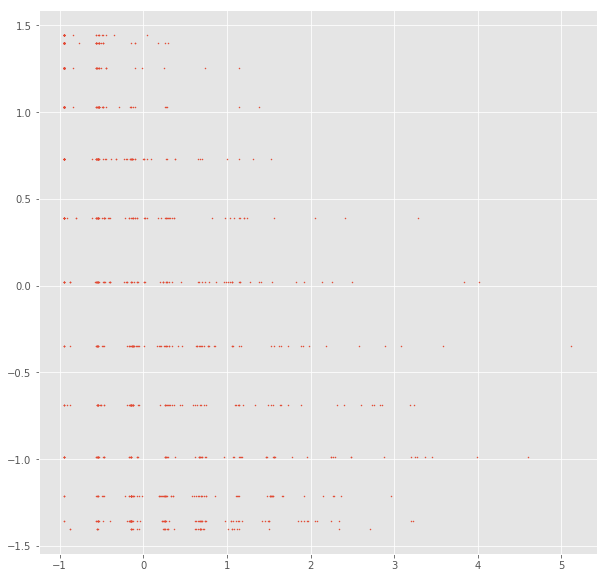

In [13]:
plt.figure(figsize=[10,10])
plt.scatter(gettraftrain_f['trafficnumbers'], gettraftrain_f['yhr'],1)

## Bin: Pollution - Traffic Values

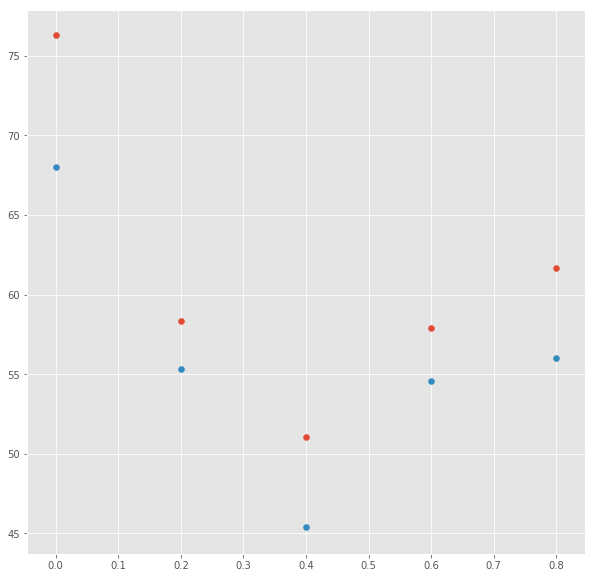

In [14]:
pol = []
polste = []
traf = []
d = 0.2
for t in np.arange(0,1,d):
    pols = gettraftest_f[(gettraftrain_f['trafficnumbers']>t) & (gettraftrain_f['trafficnumbers'] < t+d) ]
    pol.append(np.mean(pols))
    polste.append(np.std(pols)/np.sqrt(len(pols)))
    traf.append(t)
plt.figure(figsize=[10,10])
plt.scatter(traf, np.array(pol)+np.array(polste))
plt.scatter(traf, pol)

## Code module for GLMs and correlations of every 500th point

The below code module takes in the **coordinates of every 500th point** in the 3000x3000 (Google Map size) grid, runs all the above functions for the these coordinates and passes the training (only traffic data) and testing data into GLM while calculating the correlations of all the factors from traffic to all the weather factors and the target variable, pollution **measured from only one point, i.e., US Embassy**. In case there a is a point in the map that doesn't have any of the 4 mentioned colours to pick and average, the dataframe is empty and it has been handled in the exception part.

In [15]:
results_traf = []
results_humid = []
results_pret = []
results_pres = []
results_rad = []
results_temp = []
results_wind = []
results_xhr = []
results_yhr = []
allcoords = []
for coordx in range(0,3000,500):
    for coordy in range(0,3000,500):
        fetchmap = fetchMapDate()
        fetchtdf, fetchpol = fetchPollutionDate()
        fetchcorrmap = fetchCorrectMap(fetchmap, fetchpol)
        print("The coordinates are: ", coordx, ",", coordy)
        fetchtrafcol = fetchTrafficColour(fetchcorrmap, coordx, coordy, 50)
        mergewp = mergeWeatherPol(fetchtdf)
        preparedf = prepareDataFrame(fetchtrafcol, fetchpol, mergewp)    
        try: 
            X, y = getTrafficWeatherTrainTest(preparedf)
            allcoords.append([coordx,coordy])
            X = X.as_matrix()
            y = y.as_matrix()
            X2 = sm.add_constant(X[:,0])
            est = sm.OLS(y, X2)
            est2 = est.fit()
            print(est2.summary())
            results_traf.append(np.corrcoef(X[:,0],y)[0,1])
            results_humid.append(np.corrcoef(X[:,1],y)[0,1])
            results_pret.append(np.corrcoef(X[:,2],y)[0,1])
            results_pres.append(np.corrcoef(X[:,3],y)[0,1])
            results_rad.append(np.corrcoef(X[:,4],y)[0,1])
            results_temp.append(np.corrcoef(X[:,5],y)[0,1])
            results_wind.append(np.corrcoef(X[:,6],y)[0,1])
            results_xhr.append(np.corrcoef(X[:,7],y)[0,1])
            results_yhr.append(np.corrcoef(X[:,8],y)[0,1])
        except:
            print("Check if empty df", preparedf)
            print(print("The coordinates for empty df are: ", coordx, ",", coordy))        
        ###Compute correlation or whatever

The coordinates are:  0 , 0


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  0 , 0
None
The coordinates are:  0 , 500


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  0 , 500
None
The coordinates are:  0 , 1000


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linea

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Mon, 02 Sep 2019   Prob (F-statistic):                nan
Time:                        01:53:20   Log-Likelihood:                -242.84
No. Observations:                  49   AIC:                             487.7
Df Residuals:                      48   BIC:                             489.6
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.2245      4.960     14.159      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     8.049
Date:                Mon, 02 Sep 2019   Prob (F-statistic):            0.00467
Time:                        02:05:11   Log-Likelihood:                -3654.1
No. Observations:                 756   AIC:                             7312.
Df Residuals:                     754   BIC:                             7321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0516      1.107     53.333      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03737
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.847
Time:                        02:16:36   Log-Likelihood:                -2382.9
No. Observations:                 503   AIC:                             4770.
Df Residuals:                     501   BIC:                             4778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.6402      1.234     45.095      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                   0.02584
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.873
Time:                        02:27:48   Log-Likelihood:                -215.94
No. Observations:                  46   AIC:                             435.9
Df Residuals:                      44   BIC:                             439.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.8696      3.988     13.507      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  500 , 0
None
The coordinates are:  500 , 500


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.149
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.284
Time:                        02:50:03   Log-Likelihood:                -4067.1
No. Observations:                 842   AIC:                             8138.
Df Residuals:                     840   BIC:                             8148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5095      1.046     56.908      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  500 , 1000
None
The coordinates are:  500 , 1500


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3044
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.581
Time:                        03:09:00   Log-Likelihood:                -3624.5
No. Observations:                 753   AIC:                             7253.
Df Residuals:                     751   BIC:                             7262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7795      1.087     54.056      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2572
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.612
Time:                        03:18:26   Log-Likelihood:                -2811.9
No. Observations:                 579   AIC:                             5628.
Df Residuals:                     577   BIC:                             5636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2660      1.295     45.763      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  500 , 2500
None
The coordinates are:  1000 , 0


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03604
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.849
Time:                        03:37:22   Log-Likelihood:                -3452.6
No. Observations:                 714   AIC:                             6909.
Df Residuals:                     712   BIC:                             6918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7101      1.142     51.417      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.088
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0435
Time:                        03:46:48   Log-Likelihood:                -3799.6
No. Observations:                 786   AIC:                             7603.
Df Residuals:                     784   BIC:                             7613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.4338      1.086     54.703      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.096
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0137
Time:                        03:56:13   Log-Likelihood:                -4160.0
No. Observations:                 863   AIC:                             8324.
Df Residuals:                     861   BIC:                             8334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0162      1.023     57.708      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.426
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0646
Time:                        04:05:40   Log-Likelihood:                -3801.0
No. Observations:                 788   AIC:                             7606.
Df Residuals:                     786   BIC:                             7615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0977      1.074     55.034      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  1000 , 2000
None
The coordinates are:  1000 , 2500


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2260
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.635
Time:                        04:24:32   Log-Likelihood:                -4148.7
No. Observations:                 859   AIC:                             8301.
Df Residuals:                     857   BIC:                             8311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2934      1.035     57.311      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.665
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.197
Time:                        04:33:59   Log-Likelihood:                -4431.8
No. Observations:                 919   AIC:                             8868.
Df Residuals:                     917   BIC:                             8877.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5734      0.993     59.999      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     14.62
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           0.000141
Time:                        04:43:56   Log-Likelihood:                -3917.9
No. Observations:                 814   AIC:                             7840.
Df Residuals:                     812   BIC:                             7849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.8722      1.045     56.313      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.264
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0220
Time:                        04:54:17   Log-Likelihood:                -4819.9
No. Observations:                1002   AIC:                             9644.
Df Residuals:                    1000   BIC:                             9654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6088      0.939     63.457      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     45.36
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           2.77e-11
Time:                        05:04:42   Log-Likelihood:                -4782.6
No. Observations:                 998   AIC:                             9569.
Df Residuals:                     996   BIC:                             9579.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7164      0.924     64.604      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.711
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0302
Time:                        05:14:50   Log-Likelihood:                -4732.6
No. Observations:                 984   AIC:                             9469.
Df Residuals:                     982   BIC:                             9479.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5813      0.947     62.900      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


Check if empty df Empty DataFrame
Columns: [site, name, dateTimeUTC, humidity (%), precipitation (mm), pressure (kPa), radiation (W/m2), temperature (oC), winddirection, windspeed (m/s), date.local, attribution, city, coordinates.latitude, coordinates.longitude, country, location, parameter, unit, value, trafficnumbers, maps, date.utc, month, day, hour]
Index: []

[0 rows x 26 columns]
The coordinates for empty df are:  1500 , 2500
None
The coordinates are:  2000 , 0


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.492
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0621
Time:                        05:36:03   Log-Likelihood:                -3091.9
No. Observations:                 642   AIC:                             6188.
Df Residuals:                     640   BIC:                             6197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.4829      1.181     50.370      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5002
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.480
Time:                        05:46:13   Log-Likelihood:                -4686.1
No. Observations:                 972   AIC:                             9376.
Df Residuals:                     970   BIC:                             9386.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.8611      0.964     62.085      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03132
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.860
Time:                        05:56:39   Log-Likelihood:                -3096.2
No. Observations:                 648   AIC:                             6196.
Df Residuals:                     646   BIC:                             6205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.7855      1.132     49.290      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.013
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.314
Time:                        06:07:04   Log-Likelihood:                -4757.2
No. Observations:                 988   AIC:                             9518.
Df Residuals:                     986   BIC:                             9528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.8087      0.951     62.922      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.000
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.159
Time:                        06:17:30   Log-Likelihood:                -1171.2
No. Observations:                 246   AIC:                             2346.
Df Residuals:                     244   BIC:                             2354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.1748      1.811     31.578      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9025
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.343
Time:                        06:28:00   Log-Likelihood:                -2738.1
No. Observations:                 565   AIC:                             5480.
Df Residuals:                     563   BIC:                             5489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.1327      1.298     45.567      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2437
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.623
Time:                        06:38:59   Log-Likelihood:                -279.37
No. Observations:                  58   AIC:                             562.7
Df Residuals:                      56   BIC:                             566.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.1034      3.996     16.794      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.09753
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.755
Time:                        06:49:18   Log-Likelihood:                -4233.3
No. Observations:                 877   AIC:                             8471.
Df Residuals:                     875   BIC:                             8480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7469      1.021     58.504      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.238
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0127
Time:                        06:59:30   Log-Likelihood:                -4712.1
No. Observations:                 978   AIC:                             9428.
Df Residuals:                     976   BIC:                             9438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7004      0.958     62.299      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     15.80
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           7.59e-05
Time:                        07:09:43   Log-Likelihood:                -4435.5
No. Observations:                 921   AIC:                             8875.
Df Residuals:                     919   BIC:                             8885.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.8469      0.985     60.727      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01814
Date:                Mon, 02 Sep 2019   Prob (F-statistic):              0.893
Time:                        07:19:56   Log-Likelihood:                -3943.1
No. Observations:                 817   AIC:                             7890.
Df Residuals:                     815   BIC:                             7900.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.9755      1.057     55.777      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.966
Date:                Mon, 02 Sep 2019   Prob (F-statistic):             0.0853
Time:                        07:30:14   Log-Likelihood:                -4773.6
No. Observations:                 992   AIC:                             9551.
Df Residuals:                     990   BIC:                             9561.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5101      0.946     62.920      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Correlation Plots (point of pollution measurement encircled in black)

### Correlation between traffic and pollution

The traffic numbers have been multiplied by 400 to view the correlations in a better way. This shows that traffic at some points is correlated with pollution. 

/home/vijeta/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'Correlation between Traffic and Pollution')

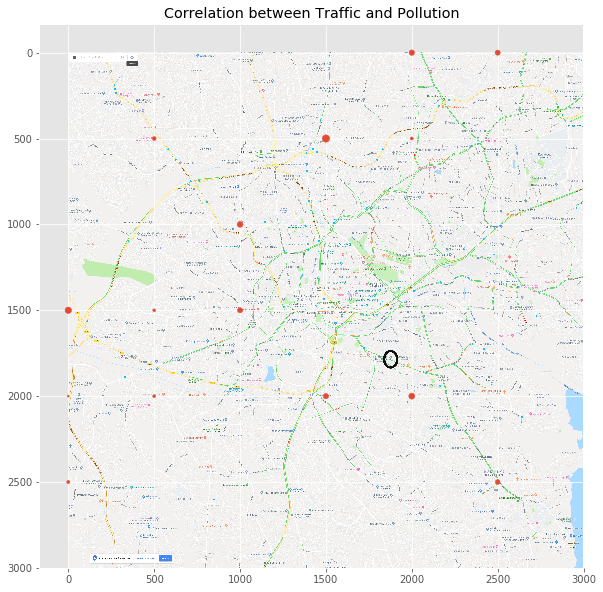

In [16]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_traf)*400)
plt.title('Correlation between Traffic and Pollution')

### Correlation between humidity and pollution

The below plot shows the correlation between humidity and pollution which suggests that there is a positive correlation between them.

Text(0.5, 1.0, 'Correlation between Humidity and Pollution')

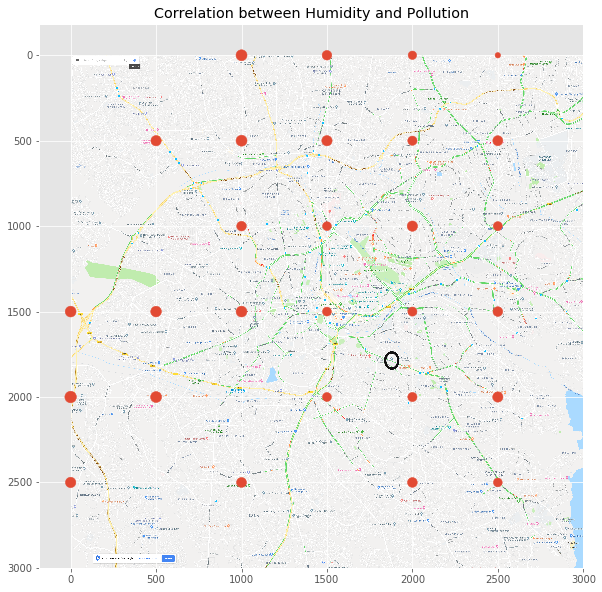

In [17]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_humid)*400)
plt.title('Correlation between Humidity and Pollution')

### Correlation between precipitation and pollution

The below plot shows the correlation between precipitation and pollution which suggests that there is a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Precipitation and Pollution')

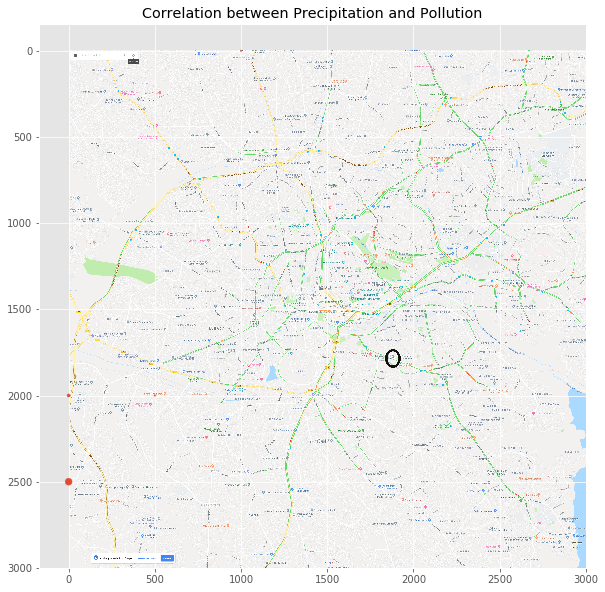

In [18]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_pret)*400)
plt.title('Correlation between Precipitation and Pollution')

### Correlation between pressure and pollution

The below plot shows the correlation between pressure and pollution which suggests that there is mostly a positive correlation between them.

Text(0.5, 1.0, 'Correlation between Pressure and Pollution')

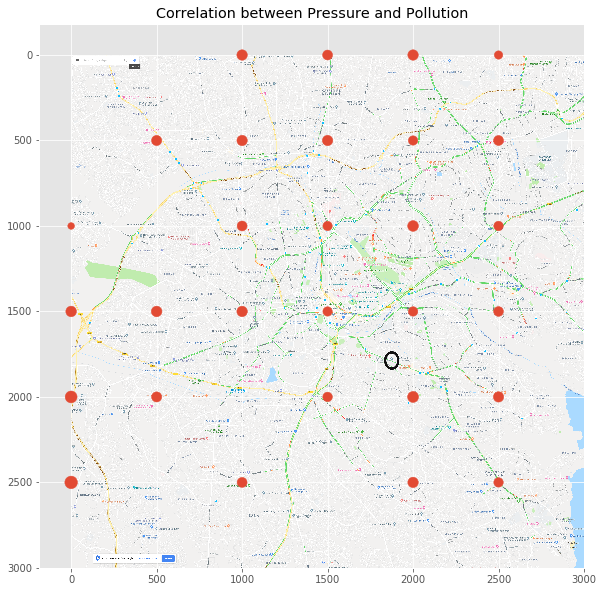

In [19]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_pres)*400)
plt.title('Correlation between Pressure and Pollution')

### Correlation between radiation and pollution

The below plot shows the correlation between radiation and pollution which suggests that there is a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Radiation and Pollution')

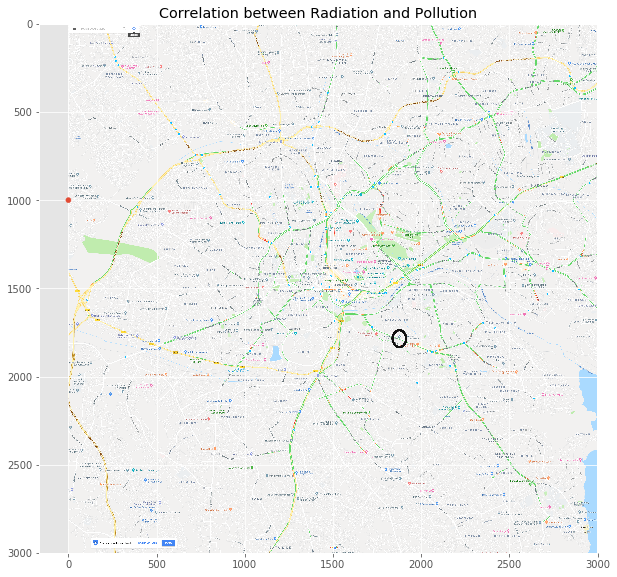

In [20]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_rad)*400)
plt.title('Correlation between Radiation and Pollution')

### Correlation between temperature and pollution

The below plot shows the correlation between temperature and pollution which suggests that there is a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Temperature and Pollution')

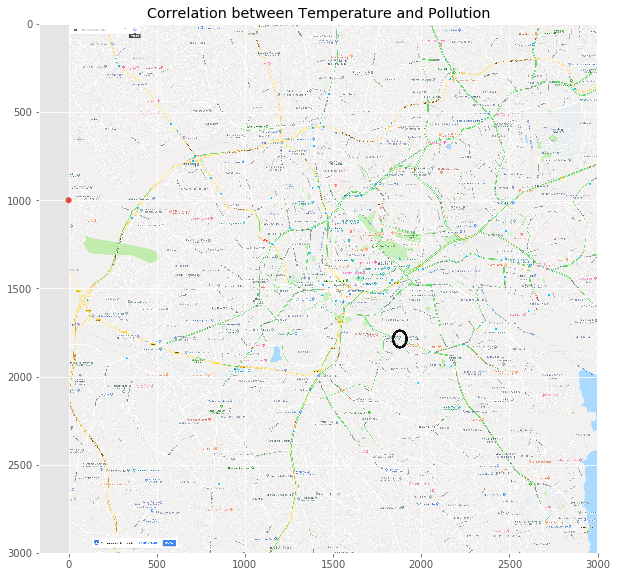

In [21]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_temp)*400)
plt.title('Correlation between Temperature and Pollution')

### Correlation between windspeed and pollution

The below plot shows the correlation between windspeed and pollution which suggests that there is a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Windspeed and Pollution')

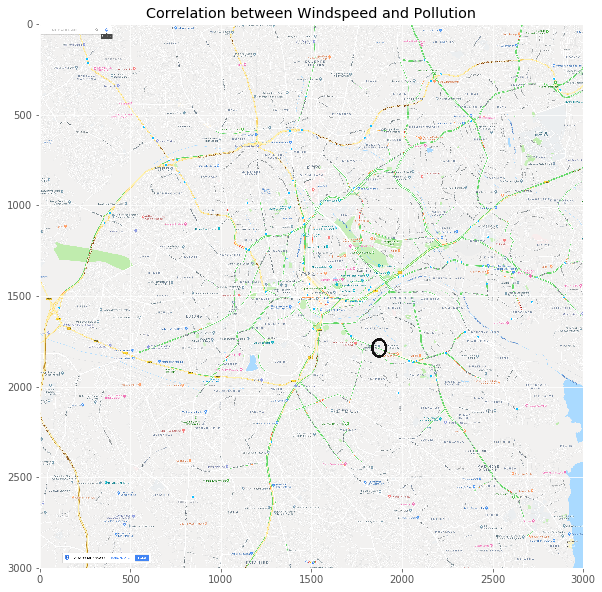

In [22]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_wind)*400)
plt.title('Correlation between Windspeed and Pollution')

### Correlation between time and pollution

The below plot shows the correlation between the sin_cycle and pollution which suggests that there is a positive and a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Sin Hour and Pollution')

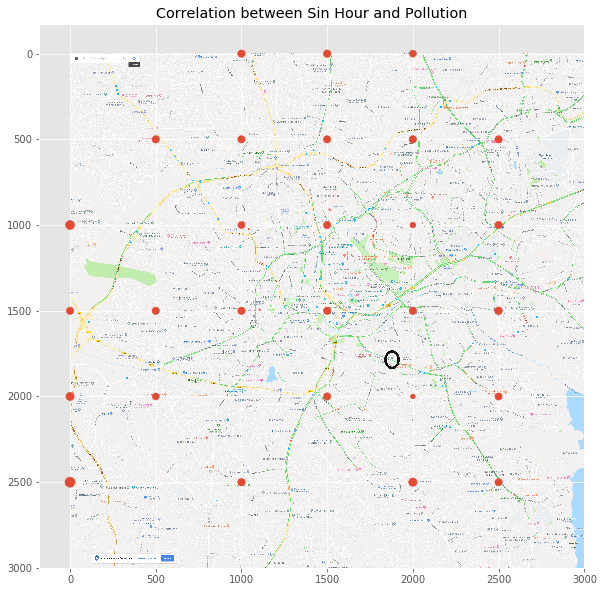

In [23]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_xhr)*400)
plt.title('Correlation between Sin Hour and Pollution')

The below plot shows the correlation between the cos_cycle and pollution which suggests that there is a positive and a negative correlation between them.

Text(0.5, 1.0, 'Correlation between Cos Hour and Pollution')

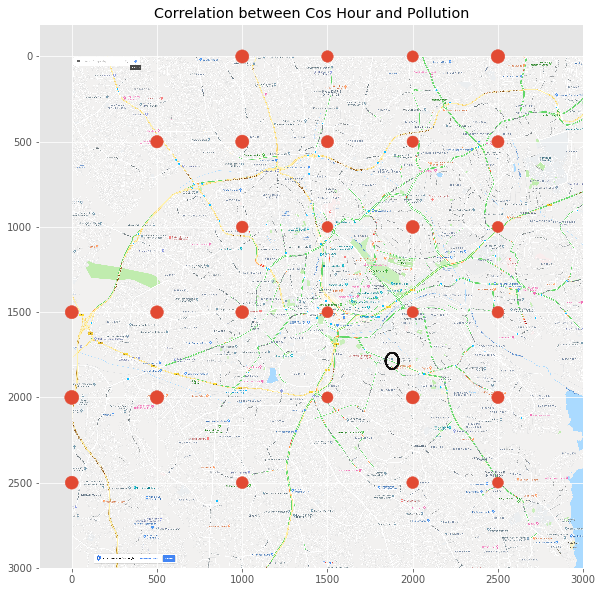

In [24]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_yhr)*400)
plt.title('Correlation between Cos Hour and Pollution')

### Calculation of RMSE and MAE for predicting pollution through traffic only

The training and testing data set, **gettraftrain_f** and **gettraftest_f** obtained previously for coordinate (1675, 1654) and circle size of 50 pixels, have been used where only the traffic numbers have been passed as the input variable (gettraftrain_arr) to predict the target variable, pollution (gettraftest_arr), after converting the dataframes to matrix format.

In [25]:
getarr = gettraftrain_f.as_matrix()
gettraftrain_arr = getarr[:,0].reshape(-1, 1)
gettraftest_arr = gettraftest_f.as_matrix()
gettrafweattrain_arr = gettrafweattrain_f.as_matrix()
gettrafweattest_arr = gettrafweattest_f.as_matrix()

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


#### Calculating the RMSE and MAE after passing them through Linear Regression:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(gettraftrain_arr, gettraftest_arr, test_size=.3, random_state=1234)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
lin_pred = regr.predict(X_test)

from math import sqrt

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, lin_pred))

Root mean squared error: 28.84
Mean absolute error: 22.66


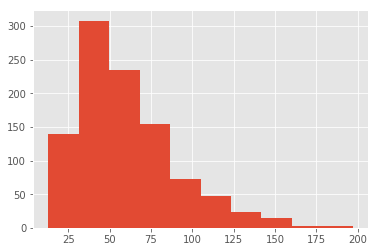

In [27]:
plt.hist(gettraftest_arr)
plt.show()

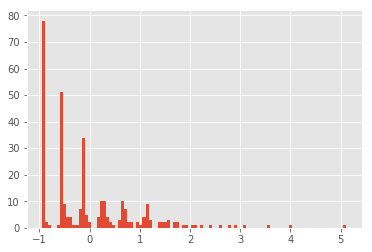

In [28]:
plt.hist(X_test, bins=100)
plt.show()

### Calculation of RMSE and MAE for predicting pollution through traffic and weather data

The training and testing data set, **gettrafweattrain_f** and **gettrafweattest_f** obtained previously for coordinates (1675, 1654) and circle size of 50 pixels, have been used where the traffic numbers along with weather data have been passed as the input variable (gettrafweattrain_arr) to predict the target variable, pollution (gettrafweattest_arr), after converting the dataframes to matrix format. Calculating the RMSE and MAE after passing them through Linear Regression:

In [29]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(gettrafweattrain_arr, gettrafweattest_arr, test_size=.3, random_state=1234)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train_all, y_train_all)
# Make predictions using the testing set
lin_pred_all = regr.predict(X_test_all)


from math import sqrt

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test_all, lin_pred_all)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test_all, lin_pred_all))

Root mean squared error: 25.95
Mean absolute error: 19.64


### GLMs for predicting pollution using only traffic for coordinate (1675, 1654) and circle size of 50 pixels

#### GLM using OLS method:

In [30]:
X = gettraftrain_arr
y = gettraftest_arr
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           0.000377
Time:                        07:30:38   Log-Likelihood:                -4803.1
No. Observations:                 999   AIC:                             9610.
Df Residuals:                     997   BIC:                             9620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.939     63.609      0.0

#### GLM using GLS method:

In [31]:
X = gettraftrain_arr
y = gettraftest_arr
X2 = sm.add_constant(X)
est = sm.GLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            GLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           0.000377
Time:                        07:30:43   Log-Likelihood:                -4803.1
No. Observations:                 999   AIC:                             9610.
Df Residuals:                     997   BIC:                             9620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.939     63.609      0.0

#### GLM using WLS method:

In [32]:
X = gettraftrain_arr
y = gettraftest_arr
X2 = sm.add_constant(X)
est = sm.WLS(y, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     12.73
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           0.000377
Time:                        07:30:43   Log-Likelihood:                -4803.1
No. Observations:                 999   AIC:                             9610.
Df Residuals:                     997   BIC:                             9620.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.939     63.609      0.0

### GLMs for predicting pollution using traffic and weather data for coordinate (1675, 1654) and circle size of 50 pixels

#### GLM using OLS method:

In [33]:
X2 = sm.add_constant(gettrafweattrain_arr)
est = sm.OLS(gettrafweattest_arr, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     27.19
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           2.74e-42
Time:                        07:30:44   Log-Likelihood:                -4699.0
No. Observations:                 999   AIC:                             9418.
Df Residuals:                     989   BIC:                             9467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.849     70.312      0.0

#### GLM using GLS method:

In [34]:
X2 = sm.add_constant(gettrafweattrain_arr)
est = sm.GLS(gettrafweattest_arr, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            GLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     27.19
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           2.74e-42
Time:                        07:30:45   Log-Likelihood:                -4699.0
No. Observations:                 999   AIC:                             9418.
Df Residuals:                     989   BIC:                             9467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.849     70.312      0.0

#### GLM using WLS method:

In [35]:
X2 = sm.add_constant(gettrafweattrain_arr)
est = sm.WLS(gettrafweattest_arr, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.198
Model:                            WLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     27.19
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           2.74e-42
Time:                        07:30:45   Log-Likelihood:                -4699.0
No. Observations:                 999   AIC:                             9418.
Df Residuals:                     989   BIC:                             9467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7027      0.849     70.312      0.0

### Function getRawGraph():

This function is used to obtain the combined data frame in its raw form without any data scaling or conversion.

In [36]:
def getRawGraph(dfclean):
    dfclean = dfclean.drop(dfclean.columns[[0, 1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22]], axis=1)
    dfclean = dfclean.dropna()
    return (dfclean)

### Calling all the above functions for coordinate (1675, 1654) and circle size of 50 pixels to get raw dataframe

In [37]:
fetchmap_r = fetchMapDate()
fetchtdf_r, fetchpol_r = fetchPollutionDate()
fetchcorrmap_r = fetchCorrectMap(fetchmap_r, fetchpol_r)

In [38]:
fetchtrafcol_r = fetchTrafficColour(fetchcorrmap_r, 1675, 1654, 50)

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [39]:
mergewp_r = mergeWeatherPol(fetchtdf_r)
preparedf_r = prepareDataFrame(fetchtrafcol_r, fetchpol_r, mergewp_r)
rawgraph_r = getRawGraph(preparedf_r)

In [40]:
rawgraph_r['trafficnumbers'] = rawgraph_r['trafficnumbers'].convert_objects(convert_numeric=True)

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


## Grouping the raw dataframe by hour having taken the mean of all the columns

In [41]:
hrg = rawgraph_r.groupby('hour').mean()
rawgraph_r

humidity (%)  precipitation (mm)  pressure (kPa)  radiation (W/m2)  \
0               83                0.00           87.59              0.00   
1               90                0.02           87.60              0.00   
2               93                0.03           87.63              0.00   
3               92                0.02           87.68              0.08   
4               93                0.02           87.72             14.18   
5               89                0.00           87.81             51.83   
6               77                0.00           87.88            304.40   
7               61                0.00           87.90            493.10   
8               58                0.00           87.88            550.48   
9               61                0.00           87.79            440.25   
10              57                0.00           87.70            674.05   
11              52                0.00           87.60            684.43   
12              53                0.00           87.53            567.18   
13              51                0.00           87.48            393.18   
14              55                0.00           87.48            211.27   
15              63                0.00           87.48             49.18   
16              72                0.00           87.50              1.03   
17              75                0.00           87.52              0.00   
18              76                0.00           87.57              0.00   
19              82                0.00           87.58              0.00   
20              88                0.00           87.59              0.00   
21              91                0.00           87.63              0.00   
22              94                0.00           87.62              0.00   
23              94                0.02           87.56              0.00   
24              87                0.02           87.53              0.00   
25              84                0.00           87.54              0.00   
26              91                0.00           87.56              0.00   
27              89                0.00           87.62              0.00   
28              84                0.00           87.68             16.92   
29              78                0.00           87.73             58.57   
...            ...                 ...             ...               ...   
1014            62                0.00           87.55              0.20   
1015            69                0.00           87.56              0.00   
1016            72                0.00           87.59              0.00   
1017            75                0.00           87.63              0.00   
1018            79                0.00           87.68              0.00   
1019            83                0.00           87.72              0.00   
1020            87                0.00           87.70              0.00   
1021            86                0.00           87.64              0.00   
1022            83                0.00           87.61              0.00   
1023            81                0.00           87.61              0.00   
1025            88                0.00           87.71              0.18   
1026            85                0.00           87.77             41.72   
1027            77                0.00           87.83            309.63   
1028            75                0.00           87.88            443.55   
1029            72                0.00           87.89            725.65   
1030            61                0.00           87.86            817.42   
1031            58                0.00           87.80            501.58   
1032            51                0.00           87.71            988.40   
1033            54                0.00           87.57            911.88   
1034            55                0.00           87.53            823.30   
1035            55                0.00           87.57

## Plots (Raw Data (Average) vs Hours (Average) for coordinate (1675, 1654) and circle size of 50 pixels)

### Plotting Traffic Values (Average) vs Hours (Average)

Text(0.5, 1.0, 'Traffic Values vs Hours')

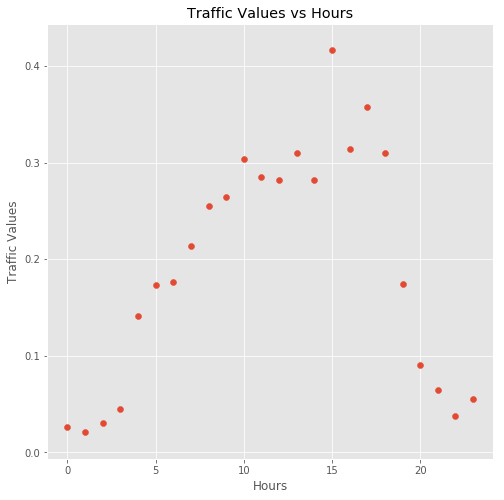

In [42]:
plt.figure(figsize=[8,8])
plt.scatter(range(0,24),hrg['trafficnumbers'])
plt.xlabel('Hours')
plt.ylabel('Traffic Values')
plt.title('Traffic Values vs Hours')

### Plotting Pollution (Average) vs Hours (Average)

Text(0.5, 1.0, 'Pollution vs Hours')

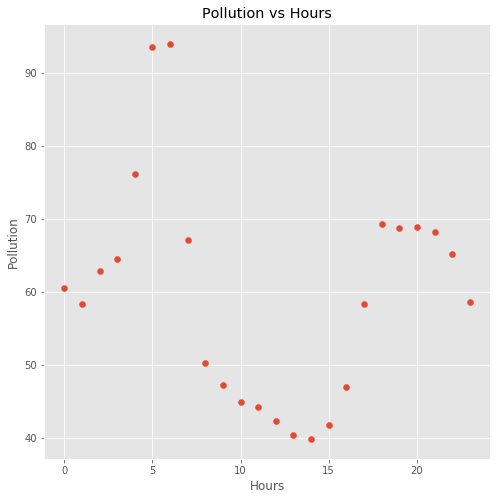

In [43]:
plt.figure(figsize=[8,8])
plt.scatter(range(0,24),hrg['value'])
plt.xlabel('Hours')
plt.ylabel('Pollution')
plt.title('Pollution vs Hours')

### Plotting Pollution (Average) vs Traffic Values (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Traffic Values')

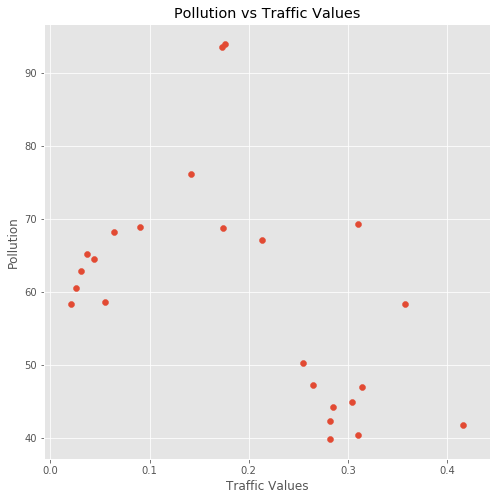

In [44]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['trafficnumbers'],hrg['value'])
plt.xlabel('Traffic Values')
plt.ylabel('Pollution')
plt.title('Pollution vs Traffic Values')

### Plotting Pollution (Average) vs Humidity (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Humidity')

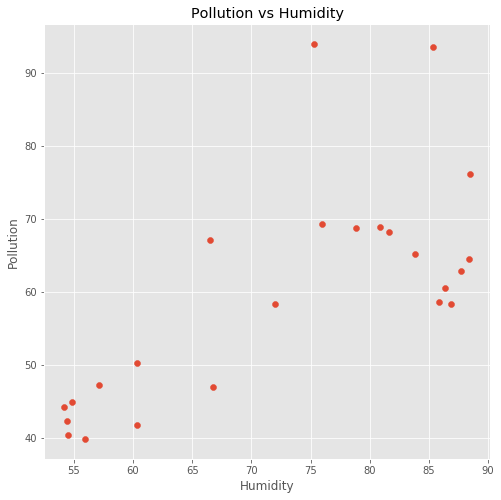

In [45]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['humidity (%)'],hrg['value'])
plt.xlabel('Humidity')
plt.ylabel('Pollution')
plt.title('Pollution vs Humidity')

### Plotting Pollution (Average) vs Precipitation (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Precipitation')

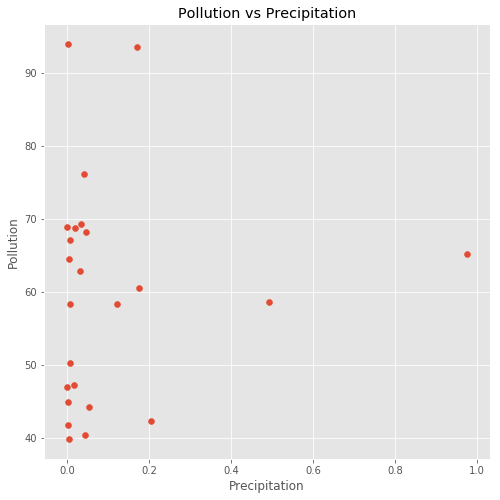

In [46]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['precipitation (mm)'],hrg['value'])
plt.xlabel('Precipitation')
plt.ylabel('Pollution')
plt.title('Pollution vs Precipitation')

### Plotting Pollution (Average) vs Pressure (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Pressure')

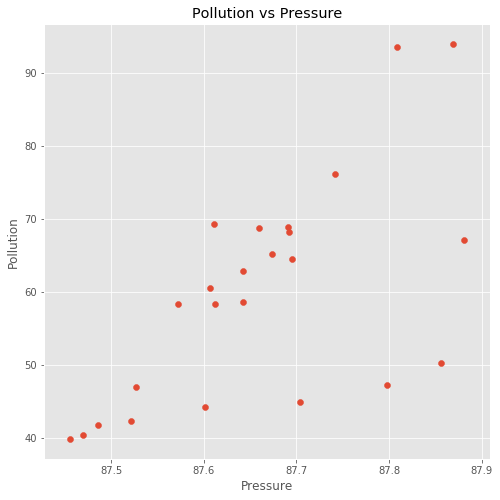

In [47]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['pressure (kPa)'],hrg['value'])
plt.xlabel('Pressure')
plt.ylabel('Pollution')
plt.title('Pollution vs Pressure')

### Plotting Pollution (Average) vs Radiation (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Radiation')

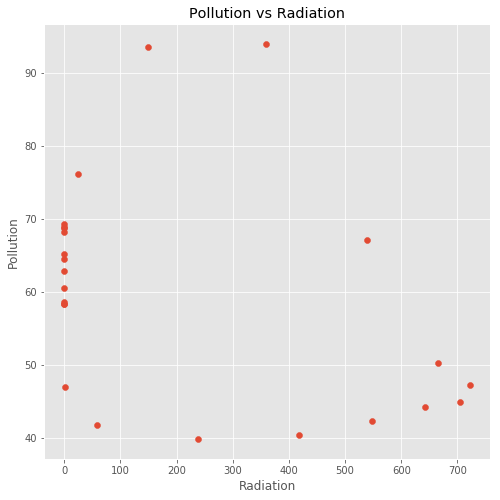

In [48]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['radiation (W/m2)'],hrg['value'])
plt.xlabel('Radiation')
plt.ylabel('Pollution')
plt.title('Pollution vs Radiation')

### Plotting Pollution (Average) vs Temperature (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Temperature')

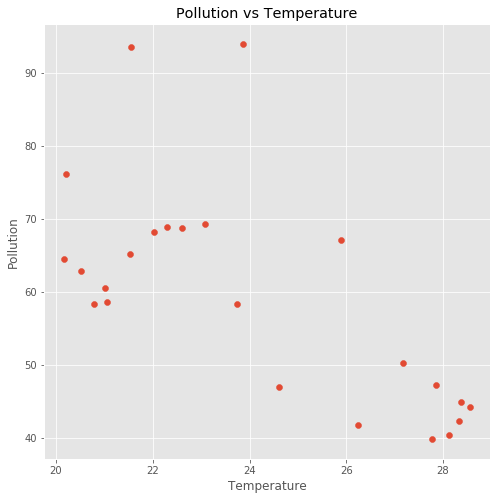

In [49]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['temperature (oC)'],hrg['value'])
plt.xlabel('Temperature')
plt.ylabel('Pollution')
plt.title('Pollution vs Temperature')

### Plotting Pollution (Average) vs Windspeed (Average) for all hours (Average)

Text(0.5, 1.0, 'Pollution vs Windspeed')

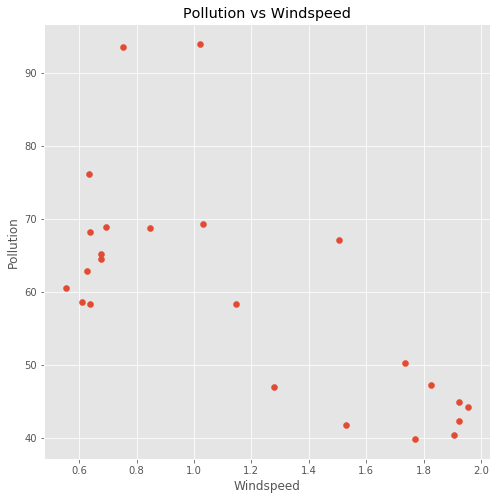

In [50]:
plt.figure(figsize=[8,8])
plt.scatter(hrg['windspeed (m/s)'],hrg['value'])
plt.xlabel('Windspeed')
plt.ylabel('Pollution')
plt.title('Pollution vs Windspeed')

## Grouping the raw dataframe by month and day having taken the mean of all the columns

In [51]:
gtp = rawgraph_r.groupby(['month', 'day']).mean()

In [52]:
gtp

humidity (%)  precipitation (mm)  pressure (kPa)  radiation (W/m2)  \
month day                                                                       
2     1       75.000000            0.004583       87.638333        184.776667   
      2       66.375000            0.001667       87.575000        208.086250   
      3       70.260870            0.004783       87.511739        213.430435   
      4       96.833333            0.025000       87.535000         13.361667   
      5       71.461538            0.000000       87.478462        115.245385   
      6       76.541667            0.004167       87.578333        168.567917   
      7       79.041667            0.003333       87.640000        137.245833   
      8       77.041667            0.001667       87.544583        175.568750   
      9       77.541667            0.000000       87.432917        134.054583   
      10      68.666667            0.000000       87.472083        186.648333   
      11      71.000000            0.000000       87.586250        106.804167   
      12      76.450000            0.003000       87.496000        182.487500   
      13      68.916667            0.005833       87.630000        205.131667   
      14      58.565217            0.000000       87.739565        213.798261   
      15      67.666667            0.082917       87.788750        133.887917   
      16      65.416667            0.000000       87.795417        239.715417   
      17      74.875000            0.061250       87.736250        153.945417   
      18      66.458333            0.019167       87.641667        167.303750   
      19      61.782609            0.000000       87.570000        227.537826   
      20      67.260870            0.000000       87.631304        225.904348   
      21      78.125000            0.868333       87.712917        226.523750   
      22      71.809524            0.177619       87.717619        256.274286   
      23      78.583333            1.578333       87.739167        238.597500   
      24      83.583333            0.243750       87.803333        227.905417   
      25      79.818182            0.037273       87.743182        268.858182   
      26      72.416667            0.000000       87.547083        278.338750   
      27      71.590909            0.000000       87.559545        329.305455   
      28      70.166667            0.001667       87.584167        238.162917   
3     1       66.541667            0.000000       87.670000        217.348333   
      2       77.583333            0.022083       87.828750        164.020417   
      3       73.833333            0.000000       87.766667        197.449583   
      4       86.130435            0.887826       87.759565        186.499130   
      5       78.130435            0.008261       87.736087        245.436522   
      6       73.208333            0.131250       87.814583        215.325000   
      7       76.772727            0.054545       87.770000        248.285455   
      8       63.958333            0.000000       87.697917        204.334167   
      9       67.272727            0.000000       87.711818        259.723182   
      10      73.347826            0.000000       87.726087        284.487391   
      13      70.500000            0.000000       87.720000        282.063750   
      14      72.750000            0.000000       87.685417        268.198750   
      15      71.250000            0.000000       87.582500        277.754167   
      16      73.500000            0.000000       87.609500        277.045500   
      17      66.666667            0.000000       87.640833        226.618333   
      18      69.590909            0.000000       87.669091        274.519091   

           temperature (oC)  windspeed (m/s)      value  trafficnumbers  \
month day                                                                 
2     1           24.462500         1.957500  83.250000        0.164208   
      2           25.173333         2.425000  56.875000    

# Plots (Raw Data (Average) vs Days for coordinate (1675, 1654) and circle size of 50 pixels)

### Plotting Traffic Values (Average) vs Days (Average)

Text(0.5, 1.0, 'Traffic Values vs Days')

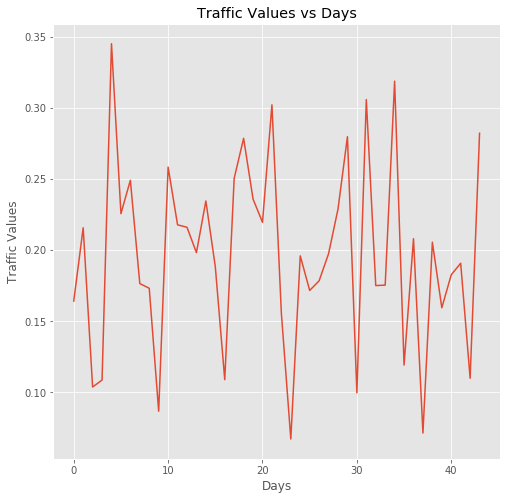

In [53]:
plt.figure(figsize=[8,8])
plt.plot(range(0,len(gtp.index)),gtp['trafficnumbers'])
plt.xlabel('Days')
plt.ylabel('Traffic Values')
plt.title('Traffic Values vs Days')

### Plotting Pollution (Average) vs Days (Average)

Text(0.5, 1.0, 'Pollution vs Days')

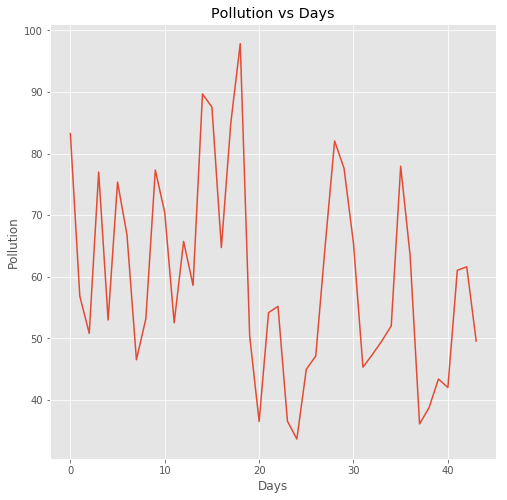

In [54]:
plt.figure(figsize=[8,8])
plt.plot(range(0,len(gtp.index)),gtp['value'])
plt.xlabel('Days')
plt.ylabel('Pollution')
plt.title('Pollution vs Days')

### Plotting Pollution (Average) vs Traffic Values (scaled 400 times to show the peaks and troughs and averaged) for all the days 

Text(0.5, 1.0, 'Pollution vs Traffic Values (scaled 400 times to see the corresponding changes)')

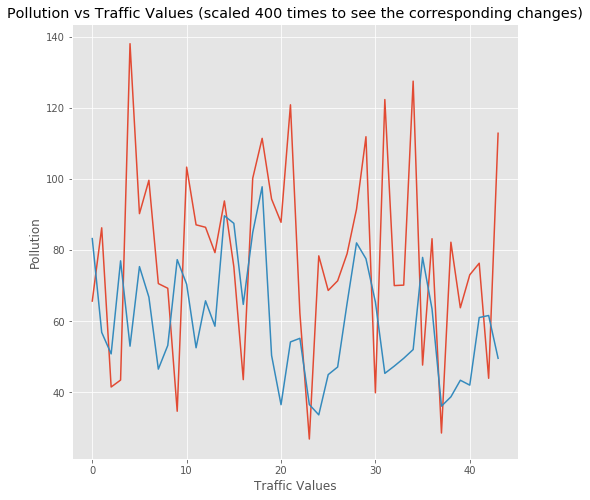

In [55]:
plt.figure(figsize=[8,8])
plt.plot(range(0,len(gtp.index)),gtp['trafficnumbers']*400)
plt.plot(range(0,len(gtp.index)),gtp['value'])
plt.xlabel('Traffic Values')
plt.ylabel('Pollution')
plt.title('Pollution vs Traffic Values (scaled 400 times to see the corresponding changes)')

### Function dataPrep():

This function takes into account only traffic, and returns an unscaled training set consisting of traffic numbers and an unscaled testing set containing pollution values.

In [56]:
def dataPrep(preparedf_mt):
    dfclean = preparedf_mt.drop(preparedf_mt.columns[[0, 1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22]], axis=1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew = dfnew.drop(dfnew.columns[[2, 3]], axis =1)
    dfnew = dfnew.drop(dfnew.columns[[2]], axis =1)
    cols = dfnew.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfnew = dfnew[cols]
    return (dfnew)

#### The below code modules take in the coordinates of those points in the maps which are a part of top 5 busiest roads of Kampala and generate a dataframe containing only the 5 traffic value columns and a pollution value column.

In [57]:
coor_hightraf = [[1590, 1490], [1559, 1602], [1932, 714], [1468, 1116], [216, 1702]]
xcoord = []
ycoord = []
for a in coor_hightraf:
    x = [a[0]]
    y = [a[1]]
    xcoord.append(x)
    ycoord.append(y)
x_co = [item for sublist in xcoord for item in sublist]
y_co = [item for sublist in ycoord for item in sublist]
results_traf_mt = []
results_humid_mt = []
results_pret_mt = []
results_pres_mt = []
results_rad_mt = []
results_temp_mt = []
results_wind_mt = []
results_xhr_mt = []
results_yhr_mt = []
# dfs = []
newDF = pd.DataFrame()
for i in range(5):
    fetchmap_mt = fetchMapDate()
    fetchtdf_mt, fetchpol_mt = fetchPollutionDate()
    fetchcorrmap_mt = fetchCorrectMap(fetchmap_mt, fetchpol_mt)
    print("The coordinates are: ", x_co[0], ",", y_co[0])
    fetchtrafcol_mt = fetchTrafficColour(fetchcorrmap_mt, x_co[0], y_co[0], 50)
    mergewp_mt = mergeWeatherPol(fetchtdf_mt)
    preparedf_mt = prepareDataFrame(fetchtrafcol_mt, fetchpol_mt, mergewp_mt)
    returndf = dataPrep(preparedf_mt)
    dfnew = returndf.rename(columns={'trafficnumbers': 'trafficnumbers_'+str(i), 'value': 'value_'+str(i)})
    newDF['trafficnumbers_'+str(i)] = dfnew['trafficnumbers_'+str(i)]
    newDF['value_'+str(i)] = dfnew['value_'+str(i)]
    print(newDF)
#     dfs.append(dfnew)
    x_co.pop(0)
    y_co.pop(0)

The coordinates are:  1590 , 1490


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


     trafficnumbers_0  value_0
0               0.273      132
1               0.073      136
2               0.903      122
3               1.796      134
4               0.396      166
5               0.673      183
6               0.995      170
7               0.928      146
8               1.307       52
9               1.289       34
10              1.180       33
11              1.303       36
12              1.284       37
13              1.492       31
14              1.536       34
15              1.246       33
16              1.202       46
17              1.315       57
18              0.791       57
19              0.797       64
20              0.397       64
21              0.237       65
22              0.218       78
23              0.296       88
24              0.066       87
25              0.021      101
26              0.079       96
27              0.413       83
28              0.055       84
29              0.586       90
...               ...      ...
1015    

The coordinates are:  1468 , 1116
     trafficnumbers_0  value_0 trafficnumbers_1  value_1 trafficnumbers_2  \
0               0.273      132            0.094    132.0            0.000   
1               0.073      136            0.111    136.0              NaN   
2               0.903      122            0.000    122.0              NaN   
3               1.796      134            0.000    134.0            0.000   
4               0.396      166            0.572    166.0            0.000   
5               0.673      183            0.706    183.0            0.887   
6               0.995      170            0.985    170.0            0.554   
7               0.928      146            1.505    146.0            0.234   
8               1.307       52            1.304     52.0            0.000   
9               1.289       34            1.156     34.0            0.227   
10              1.180       33            1.304     33.0            0.000   
11              1.303       36            

In [58]:
newDF = newDF.dropna()
newDF.dtypes

trafficnumbers_0     object
value_0               int64
trafficnumbers_1     object
value_1             float64
trafficnumbers_2     object
value_2             float64
trafficnumbers_3     object
value_3               int64
trafficnumbers_4     object
value_4             float64
dtype: object

In [59]:
highttrafdf = newDF.drop(newDF.columns[[1, 3, 5, 7]], axis =1)
highttrafdf = highttrafdf.rename(columns={'value_4': 'value'})
highttrafdf = highttrafdf.apply(pd.to_numeric)
highttrafdf

trafficnumbers_0  trafficnumbers_1  trafficnumbers_2  trafficnumbers_3  \
4                0.396             0.572             0.000             0.379   
5                0.673             0.706             0.887             0.724   
6                0.995             0.985             0.554             0.792   
7                0.928             1.505             0.234             1.013   
8                1.307             1.304             0.000             0.825   
9                1.289             1.156             0.227             0.576   
10               1.180             1.304             0.000             0.732   
11               1.303             0.872             0.030             0.695   
12               1.284             0.692             0.000             0.882   
13               1.492             0.653             0.056             0.893   
14               1.536             0.751             0.183             1.047   
15               1.246             1.047             0.684             1.068   
16               1.202             1.123             0.466             1.064   
17               1.315             1.485             0.145             1.257   
18               0.791             1.281             0.332             1.095   
19               0.797             1.073             0.731             0.459   
20               0.397             0.233             0.113             0.482   
21               0.237             0.209             0.256             0.328   
22               0.218             0.170             0.334             0.238   
23               0.296             0.148             0.429             0.458   
24               0.066             0.029             0.268             0.487   
28               0.055             0.643             0.000             0.000   
29               0.586             0.741             0.339             0.272   
30               1.158             1.062             0.082             0.307   
31               0.927             1.244             0.027             0.441   
32               0.906             1.407             0.030             0.497   
33               1.324             1.189             0.220             0.771   
34               1.376             1.157             0.055             0.617   
35               1.283             0.927             0.264             1.166   
36               0.986             0.726             0.277             1.059   
...                ...               ...               ...               ...   
1010             0.465             0.660             0.087             0.355   
1011             0.709             0.596             0.000             0.421   
1012             0.240             0.598             0.068             0.213   
1013             0.563             0.396             0.000             0.396   
1014             0.545             0.441             0.000             0.490   
1015             0.561             0.566             0.321             0.451   
1016             0.472             0.829             0.121             0.672   
1017             0.505             0.402             0.000             0.338   
1018             0.475             0.445             0.161             0.465   
1019             0.211             0.156             0.000             0.305   
1020             0.131             0.177             0.110             0.407   
1026             0.285             0.978             0.868             0.428   
1027             1.026             1.233             0.516             1.096   
1028             0.781             0.927             0.185             0.429   
1029             1.232             1.142             0.131             0.471   
1030             1.278             1.154             0.139             0.640   
1031             1.358             1.161             0.000             0.995   
1032             1.453             1.010             0.000             0.671   
1033  

### Generating the training and testing set for the above data frame

In [60]:
y_mt = highttrafdf['value']
X_mt = highttrafdf.drop(['value'], axis=1)
# X_mt = X_mt.drop(['trafficnumbers_0'], axis=1)
X_mt

trafficnumbers_0  trafficnumbers_1  trafficnumbers_2  trafficnumbers_3  \
4                0.396             0.572             0.000             0.379   
5                0.673             0.706             0.887             0.724   
6                0.995             0.985             0.554             0.792   
7                0.928             1.505             0.234             1.013   
8                1.307             1.304             0.000             0.825   
9                1.289             1.156             0.227             0.576   
10               1.180             1.304             0.000             0.732   
11               1.303             0.872             0.030             0.695   
12               1.284             0.692             0.000             0.882   
13               1.492             0.653             0.056             0.893   
14               1.536             0.751             0.183             1.047   
15               1.246             1.047             0.684             1.068   
16               1.202             1.123             0.466             1.064   
17               1.315             1.485             0.145             1.257   
18               0.791             1.281             0.332             1.095   
19               0.797             1.073             0.731             0.459   
20               0.397             0.233             0.113             0.482   
21               0.237             0.209             0.256             0.328   
22               0.218             0.170             0.334             0.238   
23               0.296             0.148             0.429             0.458   
24               0.066             0.029             0.268             0.487   
28               0.055             0.643             0.000             0.000   
29               0.586             0.741             0.339             0.272   
30               1.158             1.062             0.082             0.307   
31               0.927             1.244             0.027             0.441   
32               0.906             1.407             0.030             0.497   
33               1.324             1.189             0.220             0.771   
34               1.376             1.157             0.055             0.617   
35               1.283             0.927             0.264             1.166   
36               0.986             0.726             0.277             1.059   
...                ...               ...               ...               ...   
1010             0.465             0.660             0.087             0.355   
1011             0.709             0.596             0.000             0.421   
1012             0.240             0.598             0.068             0.213   
1013             0.563             0.396             0.000             0.396   
1014             0.545             0.441             0.000             0.490   
1015             0.561             0.566             0.321             0.451   
1016             0.472             0.829             0.121             0.672   
1017             0.505             0.402             0.000             0.338   
1018             0.475             0.445             0.161             0.465   
1019             0.211             0.156             0.000             0.305   
1020             0.131             0.177             0.110             0.407   
1026             0.285             0.978             0.868             0.428   
1027             1.026             1.233             0.516             1.096   
1028             0.781             0.927             0.185             0.429   
1029             1.232             1.142             0.131             0.471   
1030             1.278             1.154             0.139             0.640   
1031             1.358             1.161             0.000             0.995   
1032             1.453             1.010             0.000             0.671   
1033  

### Converting the training and testing sets into matrices

In [61]:
X_mt = X_mt.as_matrix()
y_mt = y_mt.as_matrix()

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


### GLMs for predicting pollution using only top 5 traffic value columns

#### GLM using OLS method:

In [62]:
X2 = sm.add_constant(X_mt)
est = sm.OLS(y_mt, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     16.67
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           1.04e-15
Time:                        08:35:14   Log-Likelihood:                -4005.5
No. Observations:                 836   AIC:                             8023.
Df Residuals:                     830   BIC:                             8051.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3857      2.679     26.274      0.0

#### GLM using GLS method:

In [63]:
X2 = sm.add_constant(X_mt)
est = sm.GLS(y_mt, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            GLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     16.67
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           1.04e-15
Time:                        08:35:14   Log-Likelihood:                -4005.5
No. Observations:                 836   AIC:                             8023.
Df Residuals:                     830   BIC:                             8051.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3857      2.679     26.274      0.0

#### GLM using WLS method:

In [64]:
X2 = sm.add_constant(X_mt)
est = sm.WLS(y_mt, X2)
est2 = est.fit()
print(est2.summary())
print('Parameters: ', est2.params)
print('R2: ', est2.rsquared)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            WLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     16.67
Date:                Mon, 02 Sep 2019   Prob (F-statistic):           1.04e-15
Time:                        08:35:14   Log-Likelihood:                -4005.5
No. Observations:                 836   AIC:                             8023.
Df Residuals:                     830   BIC:                             8051.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3857      2.679     26.274      0.0

## Linear Regression

In [65]:
# create training and testing vars
X_train_mt, X_test_mt, y_train_mt, y_test_mt = train_test_split(X_mt, y_mt, test_size=0.3, random_state=1234)

# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train_mt, y_train_mt)
predictions = lm.predict(X_test_mt)

from math import sqrt

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test_mt, predictions)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test_mt, predictions))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test_mt, predictions))

Root mean squared error: 29.17
Mean absolute error: 22.43
R-squared: 0.09


Text(0, 0.5, 'Predictions')

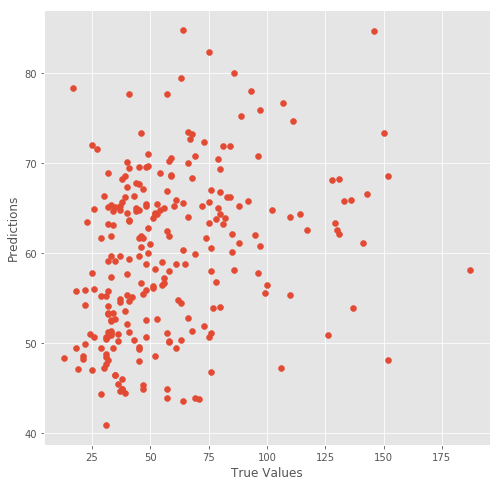

In [66]:
## The line / model
plt.figure(figsize=[8,8])
plt.scatter(y_test_mt, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Cross-Validation

In [67]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
# Perform 6-fold cross validation
scores = cross_val_score(model, X_mt, y_mt, cv=6)
print('Cross-validated scores:', scores)

Cross-validated scores: [ 0.14136122 -0.01402407 -0.19468686  0.04038629 -0.03015536 -0.43544806]


Text(0, 0.5, 'Predictions')

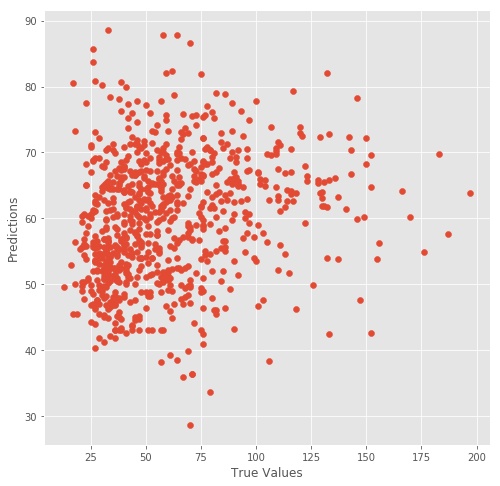

In [68]:
# Make cross validated predictions
predictions = cross_val_predict(model, X_mt, y_mt, cv=10)
## The line / model
plt.figure(figsize=[8,8])
plt.scatter(y_mt, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [69]:
R2 = metrics.r2_score(y_mt, predictions)
print ('Cross-Predicted R2:', R2)

Cross-Predicted R2: 0.034688119489342806


In [70]:
rawgraph_r.to_csv("rawdata.csv")

In [71]:
gtp.to_csv("hourgroup.csv")

# Classification

## Multiclass

In [72]:
classtrafdf = highttrafdf

In [73]:
classtrafdf['value'] = np.where(classtrafdf['value'].between(0,50), 0, classtrafdf['value'])
classtrafdf['value'] = np.where(classtrafdf['value'].between(51,100), 1, classtrafdf['value'])
classtrafdf['value'] = np.where(classtrafdf['value'].between(101,150), 2, classtrafdf['value'])
classtrafdf['value'] = classtrafdf['value'].mask(classtrafdf['value'] > 150, 3)

In [74]:
classtrafdf['value'] = classtrafdf['value'].astype(np.int64)
classtrafdf.dtypes

trafficnumbers_0    float64
trafficnumbers_1    float64
trafficnumbers_2    float64
trafficnumbers_3    float64
trafficnumbers_4    float64
value                 int64
dtype: object

In [75]:
classtrafdf

trafficnumbers_0  trafficnumbers_1  trafficnumbers_2  trafficnumbers_3  \
4                0.396             0.572             0.000             0.379   
5                0.673             0.706             0.887             0.724   
6                0.995             0.985             0.554             0.792   
7                0.928             1.505             0.234             1.013   
8                1.307             1.304             0.000             0.825   
9                1.289             1.156             0.227             0.576   
10               1.180             1.304             0.000             0.732   
11               1.303             0.872             0.030             0.695   
12               1.284             0.692             0.000             0.882   
13               1.492             0.653             0.056             0.893   
14               1.536             0.751             0.183             1.047   
15               1.246             1.047             0.684             1.068   
16               1.202             1.123             0.466             1.064   
17               1.315             1.485             0.145             1.257   
18               0.791             1.281             0.332             1.095   
19               0.797             1.073             0.731             0.459   
20               0.397             0.233             0.113             0.482   
21               0.237             0.209             0.256             0.328   
22               0.218             0.170             0.334             0.238   
23               0.296             0.148             0.429             0.458   
24               0.066             0.029             0.268             0.487   
28               0.055             0.643             0.000             0.000   
29               0.586             0.741             0.339             0.272   
30               1.158             1.062             0.082             0.307   
31               0.927             1.244             0.027             0.441   
32               0.906             1.407             0.030             0.497   
33               1.324             1.189             0.220             0.771   
34               1.376             1.157             0.055             0.617   
35               1.283             0.927             0.264             1.166   
36               0.986             0.726             0.277             1.059   
...                ...               ...               ...               ...   
1010             0.465             0.660             0.087             0.355   
1011             0.709             0.596             0.000             0.421   
1012             0.240             0.598             0.068             0.213   
1013             0.563             0.396             0.000             0.396   
1014             0.545             0.441             0.000             0.490   
1015             0.561             0.566             0.321             0.451   
1016             0.472             0.829             0.121             0.672   
1017             0.505             0.402             0.000             0.338   
1018             0.475             0.445             0.161             0.465   
1019             0.211             0.156             0.000             0.305   
1020             0.131             0.177             0.110             0.407   
1026             0.285             0.978             0.868             0.428   
1027             1.026             1.233             0.516             1.096   
1028             0.781             0.927             0.185             0.429   
1029             1.232             1.142             0.131             0.471   
1030             1.278             1.154             0.139             0.640   
1031             1.358             1.161             0.000             0.995   
1032             1.453             1.010             0.000             0.671   
1033  

In [76]:
def algo(X_cl, y_cl):
    f1_score_lr_m = []
    f1_score_rfc_m = []
    f1_score_nb_m = []
    f1_score_gc_m = []
    for size in [0.1,0.2,0.3,0.4]:
        a_train, a_test, b_train, b_test = train_test_split(X_cl, y_cl, test_size=size, random_state=1234)
        ############Logistic Regression #####################


        LR = LogisticRegression(solver='lbfgs', multi_class='auto').fit(a_train, b_train)
        predicted = LR.predict(a_test)


        ############Random Forest classifier#####################


        rf = RandomForestClassifier()
        rf.fit(a_train, b_train)
        predictions = rf.predict(a_test)


        # ######################## Naive Bayes classifier###############

        gnb = GaussianNB()
        gnb.fit(a_train, b_train)
        prediction = gnb.predict(a_test)


        ########################## Gradient Classifier###################


        gb = GradientBoostingClassifier()
        gb.fit(a_train, b_train)
        predict = gb.predict(a_test)


        # Compute Accuracy and F1 score if multiclass

        print("Accuracy, logistic regression: {0:.3f}".format(LR.score(a_test, b_test)))
        print("F1 score, logistic regression: {0:.3f}".format(f1_score(predicted, b_test, average='weighted')))
        f1_score_lr_m.append(f1_score(predicted, b_test, average='weighted'))
        print("Accuracy for RandomForestClassifier: {0:.3f}".format(metrics.accuracy_score(b_test, predictions)))
        print("F1 score, RandomForestClassifier: {0:.3f}".format(f1_score(predictions, b_test, average='weighted')))
        f1_score_rfc_m.append(f1_score(predictions, b_test, average='weighted'))
        print("Accuracy for Naive Bayes Classifier: {0:.3f}".format(metrics.accuracy_score(b_test, prediction)))
        print("F1 score, Naive Bayes: {0:.3f}".format(f1_score(prediction, b_test, average='weighted')))
        f1_score_nb_m.append(f1_score(prediction, b_test, average='weighted'))
        print("Accuracy for Gradient Boosting: {0:.3f}".format(gb.score(a_test, b_test)))
        print("F1 score, Gradient Boosting: {0:.3f}".format(f1_score(predictions, b_test, average='weighted')))
        f1_score_gc_m.append(f1_score(predict, b_test, average='weighted'))
    return ([f1_score_lr_m, f1_score_rfc_m, f1_score_nb_m, f1_score_gc_m])

print("Preparing MULTICLASS classification task")

# Split for multiclass and pass to function
y_cl = classtrafdf.iloc[:, -1]
X_cl = classtrafdf.drop(['value'], axis=1)

f1s_m = algo(X_cl, y_cl)


Preparing MULTICLASS classification task


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy, logistic regression: 0.631
F1 score, logistic regression: 0.660
Accuracy for RandomForestClassifier: 0.583
F1 score, RandomForestClassifier: 0.622
Accuracy for Naive Bayes Classifier: 0.571
F1 score, Naive Bayes: 0.598
Accuracy for Gradient Boosting: 0.571
F1 score, Gradient Boosting: 0.622


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy, logistic regression: 0.560
F1 score, logistic regression: 0.591
Accuracy for RandomForestClassifier: 0.542
F1 score, RandomForestClassifier: 0.560
Accuracy for Naive Bayes Classifier: 0.518
F1 score, Naive Bayes: 0.549
Accuracy for Gradient Boosting: 0.577
F1 score, Gradient Boosting: 0.560


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy, logistic regression: 0.574
F1 score, logistic regression: 0.603
Accuracy for RandomForestClassifier: 0.514
F1 score, RandomForestClassifier: 0.529
Accuracy for Naive Bayes Classifier: 0.550
F1 score, Naive Bayes: 0.581
Accuracy for Gradient Boosting: 0.538
F1 score, Gradient Boosting: 0.529


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy, logistic regression: 0.525
F1 score, logistic regression: 0.551
Accuracy for RandomForestClassifier: 0.499
F1 score, RandomForestClassifier: 0.510
Accuracy for Naive Bayes Classifier: 0.516
F1 score, Naive Bayes: 0.541
Accuracy for Gradient Boosting: 0.516
F1 score, Gradient Boosting: 0.510


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


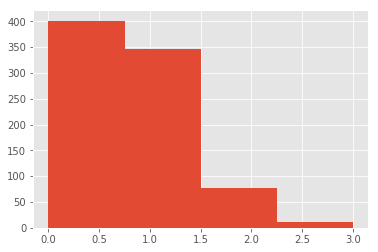

In [77]:
plt.hist(y_cl,bins=4)
plt.show()

In [78]:
f1s_m

[[0.6603018548243268,
  0.5909607990353333,
  0.6032430876881089,
  0.5507222617915487],
 [0.6222222222222222,
  0.5596908161153972,
  0.5294958098639924,
  0.5100326464463525],
 [0.5982066739739376,
  0.5491910098455495,
  0.5810234240343589,
  0.5414982606013667],
 [0.602092352092352,
  0.5939417638322747,
  0.5470646666260252,
  0.5329912266382092]]

In [79]:
lr_list_m = f1s_m[0]
rfc_list_m = f1s_m[1]
nb_list_m = f1s_m[2]
gc_list_m = f1s_m[3]

In [81]:
x_axis = [0.1, 0.2, 0.3, 0.4]

Text(0.5, 1.0, 'F1-scores vs Test-size for Multiclass')

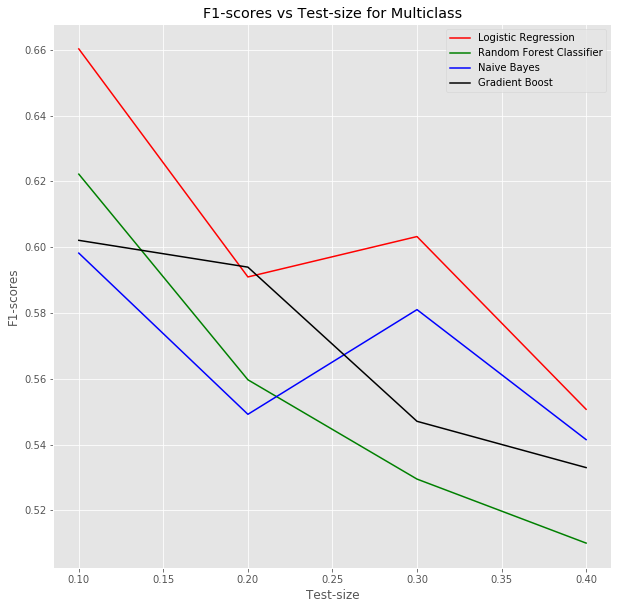

In [82]:
plt.figure(figsize=[10, 10])
plt.plot(x_axis, lr_list_m, 'r-', label = 'Logistic Regression')
plt.plot(x_axis, rfc_list_m, 'g-', label = 'Random Forest Classifier')
plt.plot(x_axis, nb_list_m, 'b-', label = 'Naive Bayes')
plt.plot(x_axis, gc_list_m, 'black', label = 'Gradient Boost')
plt.legend(loc='upper right')
plt.xlabel('Test-size')
plt.ylabel('F1-scores')
plt.title('F1-scores vs Test-size for Multiclass')

## Binary

In [83]:
highttrafdf = newDF.drop(newDF.columns[[1, 3, 5, 7]], axis =1)
highttrafdf = highttrafdf.rename(columns={'value_4': 'value'})
highttrafdf = highttrafdf.apply(pd.to_numeric)
highttrafdf

trafficnumbers_0  trafficnumbers_1  trafficnumbers_2  trafficnumbers_3  \
4                0.396             0.572             0.000             0.379   
5                0.673             0.706             0.887             0.724   
6                0.995             0.985             0.554             0.792   
7                0.928             1.505             0.234             1.013   
8                1.307             1.304             0.000             0.825   
9                1.289             1.156             0.227             0.576   
10               1.180             1.304             0.000             0.732   
11               1.303             0.872             0.030             0.695   
12               1.284             0.692             0.000             0.882   
13               1.492             0.653             0.056             0.893   
14               1.536             0.751             0.183             1.047   
15               1.246             1.047             0.684             1.068   
16               1.202             1.123             0.466             1.064   
17               1.315             1.485             0.145             1.257   
18               0.791             1.281             0.332             1.095   
19               0.797             1.073             0.731             0.459   
20               0.397             0.233             0.113             0.482   
21               0.237             0.209             0.256             0.328   
22               0.218             0.170             0.334             0.238   
23               0.296             0.148             0.429             0.458   
24               0.066             0.029             0.268             0.487   
28               0.055             0.643             0.000             0.000   
29               0.586             0.741             0.339             0.272   
30               1.158             1.062             0.082             0.307   
31               0.927             1.244             0.027             0.441   
32               0.906             1.407             0.030             0.497   
33               1.324             1.189             0.220             0.771   
34               1.376             1.157             0.055             0.617   
35               1.283             0.927             0.264             1.166   
36               0.986             0.726             0.277             1.059   
...                ...               ...               ...               ...   
1010             0.465             0.660             0.087             0.355   
1011             0.709             0.596             0.000             0.421   
1012             0.240             0.598             0.068             0.213   
1013             0.563             0.396             0.000             0.396   
1014             0.545             0.441             0.000             0.490   
1015             0.561             0.566             0.321             0.451   
1016             0.472             0.829             0.121             0.672   
1017             0.505             0.402             0.000             0.338   
1018             0.475             0.445             0.161             0.465   
1019             0.211             0.156             0.000             0.305   
1020             0.131             0.177             0.110             0.407   
1026             0.285             0.978             0.868             0.428   
1027             1.026             1.233             0.516             1.096   
1028             0.781             0.927             0.185             0.429   
1029             1.232             1.142             0.131             0.471   
1030             1.278             1.154             0.139             0.640   
1031             1.358             1.161             0.000             0.995   
1032             1.453             1.010             0.000             0.671   
1033  

In [84]:
bclasstrafdf = highttrafdf

In [85]:
bclasstrafdf['value'] = np.where(bclasstrafdf['value'].between(0,50), 0, bclasstrafdf['value'])
bclasstrafdf['value'] = bclasstrafdf['value'].mask(bclasstrafdf['value'] > 50, 1)
bclasstrafdf['value'] = bclasstrafdf['value'].astype(np.int64)
bclasstrafdf

trafficnumbers_0  trafficnumbers_1  trafficnumbers_2  trafficnumbers_3  \
4                0.396             0.572             0.000             0.379   
5                0.673             0.706             0.887             0.724   
6                0.995             0.985             0.554             0.792   
7                0.928             1.505             0.234             1.013   
8                1.307             1.304             0.000             0.825   
9                1.289             1.156             0.227             0.576   
10               1.180             1.304             0.000             0.732   
11               1.303             0.872             0.030             0.695   
12               1.284             0.692             0.000             0.882   
13               1.492             0.653             0.056             0.893   
14               1.536             0.751             0.183             1.047   
15               1.246             1.047             0.684             1.068   
16               1.202             1.123             0.466             1.064   
17               1.315             1.485             0.145             1.257   
18               0.791             1.281             0.332             1.095   
19               0.797             1.073             0.731             0.459   
20               0.397             0.233             0.113             0.482   
21               0.237             0.209             0.256             0.328   
22               0.218             0.170             0.334             0.238   
23               0.296             0.148             0.429             0.458   
24               0.066             0.029             0.268             0.487   
28               0.055             0.643             0.000             0.000   
29               0.586             0.741             0.339             0.272   
30               1.158             1.062             0.082             0.307   
31               0.927             1.244             0.027             0.441   
32               0.906             1.407             0.030             0.497   
33               1.324             1.189             0.220             0.771   
34               1.376             1.157             0.055             0.617   
35               1.283             0.927             0.264             1.166   
36               0.986             0.726             0.277             1.059   
...                ...               ...               ...               ...   
1010             0.465             0.660             0.087             0.355   
1011             0.709             0.596             0.000             0.421   
1012             0.240             0.598             0.068             0.213   
1013             0.563             0.396             0.000             0.396   
1014             0.545             0.441             0.000             0.490   
1015             0.561             0.566             0.321             0.451   
1016             0.472             0.829             0.121             0.672   
1017             0.505             0.402             0.000             0.338   
1018             0.475             0.445             0.161             0.465   
1019             0.211             0.156             0.000             0.305   
1020             0.131             0.177             0.110             0.407   
1026             0.285             0.978             0.868             0.428   
1027             1.026             1.233             0.516             1.096   
1028             0.781             0.927             0.185             0.429   
1029             1.232             1.142             0.131             0.471   
1030             1.278             1.154             0.139             0.640   
1031             1.358             1.161             0.000             0.995   
1032             1.453             1.010             0.000             0.671   
1033  

In [86]:
def algoBinary(X_bcl, y_bcl):
    f1_score_lr = []
    f1_score_rfc = []
    f1_score_nb = []
    f1_score_gc = []
    for size in [0.1,0.2,0.3,0.4]:

        ############Logistic Regression #####################
        a_train, a_test, b_train, b_test = train_test_split(X_bcl, y_bcl, test_size=size, random_state=1234)

        LR = LogisticRegression(solver='lbfgs', multi_class='auto').fit(a_train, b_train)
        predicted = LR.predict(a_test)


        ############Random Forest classifier#####################


        rf = RandomForestClassifier()
        rf.fit(a_train, b_train)
        predictions = rf.predict(a_test)


        # ######################## Naive Bayes classifier###############

        gnb = GaussianNB()
        gnb.fit(a_train, b_train)
        prediction = gnb.predict(a_test)


        ########################## Gradient Classifier###################


        gb = GradientBoostingClassifier()
        gb.fit(a_train, b_train)
        predict = gb.predict(a_test)
        # Compute Accuracy and F1 score if binary

        print("Accuracy, logistic regression: {0:.3f}".format(LR.score(a_test, b_test)))
        print("F1 score, logistic regression: {0:.3f}".format(f1_score(predicted, b_test)))
        f1_score_lr.append(f1_score(predicted, b_test))
        print("Accuracy for RandomForestClassifier: {0:.3f}".format(metrics.accuracy_score(b_test, predictions)))
        print("F1 score, RandomForestClassifier: {0:.3f}".format(f1_score(predictions, b_test)))
        f1_score_rfc.append(f1_score(predictions, b_test))
        print("Accuracy for Naive Bayes Classifier: {0:.3f}".format(metrics.accuracy_score(b_test, prediction)))
        print("F1 score, Naive Bayes: {0:.3f}".format(f1_score(prediction, b_test)))
        f1_score_nb.append(f1_score(prediction, b_test))
        print("Accuracy for Gradient Boosting: {0:.3f}".format(gb.score(a_test, b_test)))
        print("F1 score, Gradient Boosting: {0:.3f}".format(f1_score(predictions, b_test)))
        f1_score_gc.append(f1_score(predict, b_test))
    return ([f1_score_lr, f1_score_rfc, f1_score_nb, f1_score_gc])

print("Preparing BINARY classification task")

y_bcl = bclasstrafdf.iloc[:, -1]
X_bcl = bclasstrafdf.drop(['value'], axis=1)


f1s = algoBinary(X_bcl, y_bcl)

Preparing BINARY classification task


/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy, logistic regression: 0.667
F1 score, logistic regression: 0.689
Accuracy for RandomForestClassifier: 0.655
F1 score, RandomForestClassifier: 0.642
Accuracy for Naive Bayes Classifier: 0.655
F1 score, Naive Bayes: 0.651
Accuracy for Gradient Boosting: 0.655
F1 score, Gradient Boosting: 0.642
Accuracy, logistic regression: 0.643
F1 score, logistic regression: 0.674
Accuracy for RandomForestClassifier: 0.577
F1 score, RandomForestClassifier: 0.536
Accuracy for Naive Bayes Classifier: 0.577
F1 score, Naive Bayes: 0.570
Accuracy for Gradient Boosting: 0.631
F1 score, Gradient Boosting: 0.536
Accuracy, logistic regression: 0.625
F1 score, logistic regression: 0.662
Accuracy for RandomForestClassifier: 0.637
F1 score, RandomForestClassifier: 0.626
Accuracy for Naive Bayes Classifier: 0.594
F1 score, Naive Bayes: 0.582
Accuracy for Gradient Boosting: 0.606
F1 score, Gradient Boosting: 0.626
Accuracy, logistic regression: 0.606
F1 score, logistic regression: 0.631
Accuracy for RandomF

/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


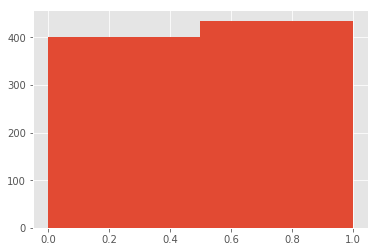

In [87]:
plt.hist(y_bcl,bins=2)
plt.show()

In [88]:
f1s

[[0.688888888888889,
  0.6739130434782609,
  0.6618705035971223,
  0.6312849162011174],
 [0.6419753086419753,
  0.5359477124183006,
  0.6255144032921811,
  0.5350318471337578],
 [0.6506024096385542,
  0.5696969696969697,
  0.5819672131147541,
  0.5493827160493827],
 [0.6588235294117647,
  0.6352941176470588,
  0.6117647058823529,
  0.5947521865889212]]

In [89]:
lr_list = f1s[0]
rfc_list = f1s[1]
nb_list = f1s[2]
gc_list = f1s[3]

Text(0.5, 1.0, 'F1-scores vs Test-size for Binary')

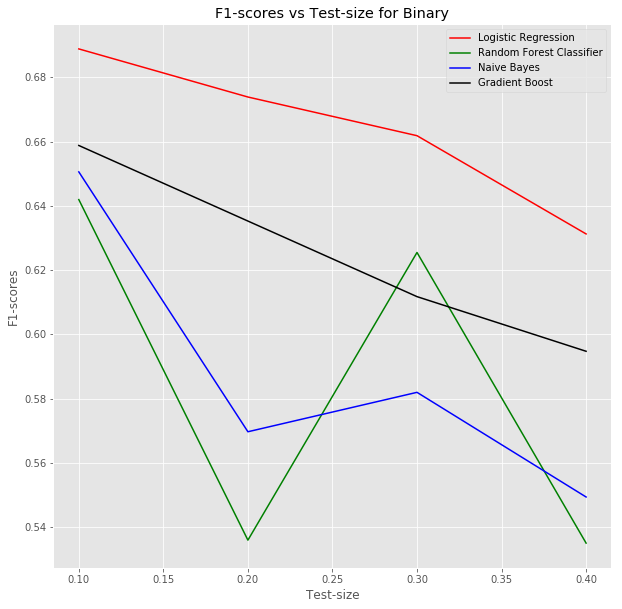

In [90]:
plt.figure(figsize=[10, 10])
plt.plot(x_axis, lr_list, 'r-', label = 'Logistic Regression')
plt.plot(x_axis, rfc_list, 'g-', label = 'Random Forest Classifier')
plt.plot(x_axis, nb_list, 'b-', label = 'Naive Bayes')
plt.plot(x_axis, gc_list, 'black', label = 'Gradient Boost')
plt.legend(loc='upper right')
plt.xlabel('Test-size')
plt.ylabel('F1-scores')
plt.title('F1-scores vs Test-size for Binary')